In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import config
from src.datasets import TextConcatFactCheck, TextConcatPosts

tasks_path = config.TASKS_PATH
posts_path = config.POSTS_PATH
fact_checks_path = config.FACT_CHECKS_PATH
gs_path = config.GS_PATH
lang = 'deu'
task_name = "monolingual"

fc = TextConcatFactCheck(fact_checks_path, tasks_path=tasks_path, task_name=task_name, lang=lang)
posts = TextConcatPosts(posts_path, tasks_path=tasks_path, task_name=task_name, lang=lang, gs_path=gs_path)

In [2]:
df_train_posts = posts.df_train
df_dev_posts = posts.df_dev
df_fc = fc.df

In [3]:
from src.models import EmbeddingModel, CrossencoderModel

teacher_model_path = '/home/bsc/bsc830651/.cache/huggingface/hub/models--intfloat--multilingual-e5-large/snapshots/ab10c1a7f42e74530fe7ae5be82e6d4f11a719eb'
teacher_model = EmbeddingModel(model_name=teacher_model_path, df_fc=df_fc, batch_size=512, k=100000)

/home/bsc/bsc830651/.conda/envs/factcheck/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
Batches: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


In [4]:
# idx, sim = model_candidates.predict(df_train_posts["full_text"].values, scores=True)
# df_train_posts["preds"], df_train_posts["sim"] = idx.tolist(), sim.tolist()

# df_train_posts["mean_sim"] = df_train_posts["sim"].apply(lambda x: np.mean(x))
# df_train_posts["max_sim"] = df_train_posts["sim"].apply(lambda x: np.max(x))

# idx = model_candidates.predict(df_train_posts["full_text"].values, scores=False)
# df_train_posts["preds"]= idx.tolist()

In [5]:
idx, sim = teacher_model.predict(df_train_posts["full_text"].values, scores=True, limit_k=False)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


In [6]:
idx

array([[ 53380,  89646,  68275, ...,  68279,  71242, 146274],
       [150241,  45555, 113947, ...,  45339,  39505, 146274],
       [ 98619,  92397,  68305, ...,  64521,  39505, 146274],
       ...,
       [ 49624,  49626,  45048, ..., 150246,  39505, 146274],
       [ 92812,  92811,  49494, ...,  27845,  39505, 146274],
       [ 95567,  45110,  27849, ..., 155918,  39505, 146274]])

In [7]:
d_idx_to_pos = {idx: pos for pos, idx in teacher_model.pos_to_idx.items()}

In [8]:
df_train_posts_pairs = df_train_posts[["full_text", "gs"]].copy()
df_train_posts_pairs["post_pos"] = np.arange(len(df_train_posts_pairs))
df_train_posts_pairs = df_train_posts_pairs.explode("gs", ignore_index=True)
d_fc_idx_text = df_fc["full_text"].to_dict()
df_train_posts_pairs["gs_text"] = df_train_posts_pairs["gs"].map(d_fc_idx_text)
df_train_posts_pairs

,full_text,gs,post_pos,gs_text
0,! Dreister Impf-Fake von Markus Söder! Es ist ...,87108,0,"nein, markus söder hat seine impfung nicht vor..."
1,"""Die Not wird die Menschen zwingen sich zu beu...",150241,1,es gibt keine beweise für diesen satz von wolf...
2,"""EIN VOLK, DAS KORRUPTE, VERRÄTER, HOCHSTAPLER...",98619,2,experten und orwell-archive kennen dieses ange...
3,"""Man kann nicht Vizekanzler und Innenminister ...",118585,3,es gibt keine belege für dieses ermittlungs-zi...
4,"""Wir können nicht sagen, mit Omikron hören wir...",77239,4,erfundenes zitat: lauterbach sagte nichts über...
...,...,...,...,...
762,🛑 EINIGE LÄNDER BENUTZEN DIE BOOSTER IMPFUNG ...,148504,602,vorsicht vor dieser fehlinterpretation einer e...
763,Weitergeleitete Nachricht Von [USER] 1:33 #RES...,49624,603,"dieses video zeigt keinen geimpften mann, der ..."
764,tz POCKET f FACEBOOK TWITTER EMAIL FEEDBACK MÜ...,92811,604,"nein, natalia klitschko wohnt nicht in einer s..."
765,tz POCKET f FACEBOOK TWITTER EMAIL FEEDBACK MÜ...,92812,604,natalia klitschko wohnt nicht auf kosten der b...


In [9]:
sorted_sim = np.sort(sim, axis=1)[:, ::-1]

df_train_posts_pairs["gs_pos"] = df_train_posts_pairs["gs"].map(d_idx_to_pos)
df_train_posts_pairs["gs_score"] = df_train_posts_pairs.apply(lambda x: sim[x["post_pos"], x["gs_pos"]], axis=1)
df_train_posts_pairs["neg_thres"] = df_train_posts_pairs["gs_score"] * 0.9
df_train_posts_pairs["naive_topk"] = df_train_posts_pairs.apply(lambda x: idx[x["post_pos"]][idx[x["post_pos"]] != x["gs_pos"]][:4], axis=1)

mask_neg_thres = lambda col1, col2: sorted_sim[col1] < col2
mask_exclude_gs = lambda col1, col2: idx[col1] != col2

df_train_posts_pairs["idx_neg_thres"] = df_train_posts_pairs.apply(lambda x: idx[x["post_pos"]][(mask_neg_thres(x["post_pos"], x["neg_thres"])&\
                                                                                                 mask_exclude_gs(x["post_pos"], x["gs"]))][:4], axis=1)
df_train_posts_pairs

,full_text,gs,post_pos,gs_text,gs_pos,gs_score,neg_thres,naive_topk,idx_neg_thres
0,! Dreister Impf-Fake von Markus Söder! Es ist ...,87108,0,"nein, markus söder hat seine impfung nicht vor...",3745,0.859888,0.773899,"[53380, 89646, 68275, 45567]","[78183, 49692, 118604, 23202]"
1,"""Die Not wird die Menschen zwingen sich zu beu...",150241,1,es gibt keine beweise für diesen satz von wolf...,4764,0.907594,0.816834,"[150241, 45555, 113947, 23340]","[62657, 31542, 33325, 1470]"
2,"""EIN VOLK, DAS KORRUPTE, VERRÄTER, HOCHSTAPLER...",98619,2,experten und orwell-archive kennen dieses ange...,4025,0.880088,0.792079,"[98619, 92397, 68305, 43935]","[92377, 62016, 65051, 53231]"
3,"""Man kann nicht Vizekanzler und Innenminister ...",118585,3,es gibt keine belege für dieses ermittlungs-zi...,4237,0.841569,0.757412,"[151811, 118797, 118586, 45628]","[29972, 149881, 120672, 43982]"
4,"""Wir können nicht sagen, mit Omikron hören wir...",77239,4,erfundenes zitat: lauterbach sagte nichts über...,3533,0.930333,0.837299,"[77239, 44056, 49733, 77238]","[70008, 53316, 42559, 91721]"
...,...,...,...,...,...,...,...,...,...
762,🛑 EINIGE LÄNDER BENUTZEN DIE BOOSTER IMPFUNG ...,148504,602,vorsicht vor dieser fehlinterpretation einer e...,4642,0.899674,0.809706,"[148504, 44037, 42713, 78381]","[44051, 45107, 71576, 88318]"
763,Weitergeleitete Nachricht Von [USER] 1:33 #RES...,49624,603,"dieses video zeigt keinen geimpften mann, der ...",2193,0.890423,0.801381,"[49624, 49626, 45048, 133739]","[107261, 53336, 49675, 110030]"
764,tz POCKET f FACEBOOK TWITTER EMAIL FEEDBACK MÜ...,92811,604,"nein, natalia klitschko wohnt nicht in einer s...",3953,0.861769,0.775592,"[92812, 92811, 49494, 136508]","[134737, 45474, 49760, 49603]"
765,tz POCKET f FACEBOOK TWITTER EMAIL FEEDBACK MÜ...,92812,604,natalia klitschko wohnt nicht auf kosten der b...,3954,0.902228,0.812006,"[92812, 92811, 49494, 136508]","[27908, 45405, 57775, 42612]"


In [10]:
df_negatives = df_train_posts_pairs[["full_text", "idx_neg_thres"]].copy()
df_negatives = df_negatives.explode("idx_neg_thres", ignore_index=True)
df_negatives["neg_text"] = df_negatives["idx_neg_thres"].map(d_fc_idx_text)
df_negatives["label"] = 0
df_negatives.drop(columns="idx_neg_thres", inplace=True)
df_negatives.head()

,full_text,neg_text,label
0,! Dreister Impf-Fake von Markus Söder! Es ist ...,"arbeitsplätze, steuern, korruption: 11 behaupt...",0
1,! Dreister Impf-Fake von Markus Söder! Es ist ...,aufnahmen zeigen keine brennenden reifen in af...,0
2,! Dreister Impf-Fake von Markus Söder! Es ist ...,"nein, diese menschen haben nicht an eine kirch...",0
3,! Dreister Impf-Fake von Markus Söder! Es ist ...,"lockdown in schanghai: hafen betroffen, aber n...",0
4,"""Die Not wird die Menschen zwingen sich zu beu...","nein, flüchtlinge dürfen obdachlose nicht stra...",0


In [11]:
df_positives = df_train_posts_pairs[["full_text", "gs_text"]].copy()
df_positives["label"] = 1
df_positives.head()

,full_text,gs_text,label
0,! Dreister Impf-Fake von Markus Söder! Es ist ...,"nein, markus söder hat seine impfung nicht vor...",1
1,"""Die Not wird die Menschen zwingen sich zu beu...",es gibt keine beweise für diesen satz von wolf...,1
2,"""EIN VOLK, DAS KORRUPTE, VERRÄTER, HOCHSTAPLER...",experten und orwell-archive kennen dieses ange...,1
3,"""Man kann nicht Vizekanzler und Innenminister ...",es gibt keine belege für dieses ermittlungs-zi...,1
4,"""Wir können nicht sagen, mit Omikron hören wir...",erfundenes zitat: lauterbach sagte nichts über...,1


In [12]:
df_negatives.rename(columns={"full_text": "query", "neg_text": "passage"}, inplace=True)
df_positives.rename(columns={"full_text": "query", "gs_text": "passage"}, inplace=True)

df_cl = pd.concat([df_positives, df_negatives], ignore_index=True)
df_cl.sort_values(["query", "label"], ascending=[True, False])

,query,passage,label
113,"""Der Schwangere Ken""😳 Was ist das wieder für ...",bei dieser werbung für eine schwangere ken-pup...,1
1219,"""Der Schwangere Ken""😳 Was ist das wieder für ...",verhaftung eines managers des pharmakonzerns p...,0
1220,"""Der Schwangere Ken""😳 Was ist das wieder für ...",edtstadler-delegation verursachte fahrtkosten ...,0
1221,"""Der Schwangere Ken""😳 Was ist das wieder für ...","ja, wegen einer rentenerhöhung müssen 48.000 r...",0
1222,"""Der Schwangere Ken""😳 Was ist das wieder für ...",butscha: bürgermeister sprach schon vor russis...,0
...,...,...,...
1214,✓ RADIO & TV Niedersachsen Stand: 30.11.2021 1...,hamburger schulen fast jede vierte klassenfahr...,0
1215,✓ RADIO & TV Niedersachsen Stand: 30.11.2021 1...,sind nur drei prozent von den in italien ankom...,0
1216,✓ RADIO & TV Niedersachsen Stand: 30.11.2021 1...,das ukrainische militär hat aktuell keine wehr...,0
1217,✓ RADIO & TV Niedersachsen Stand: 30.11.2021 1...,"ja, dieses video ist echt, aber wiesbaden ist ...",0


array([[<Axes: title={'center': 'label'}>]], dtype=object)

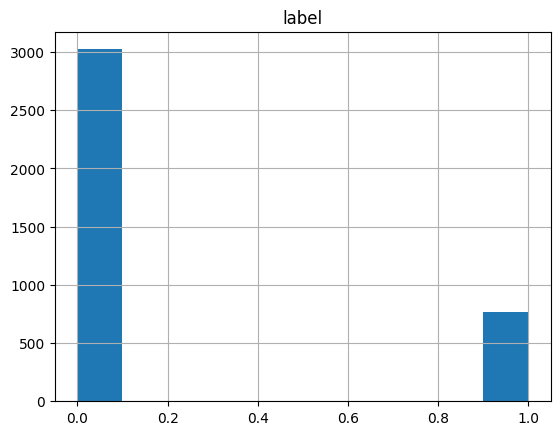

In [13]:
df_cl.hist(column="label")

In [14]:
# reload library
import src.models
from importlib import reload
reload(src.models)

# model_ce = "jinaai/jina-reranker-v2-base-multilingual"
# model_ce = CrossencoderModel(model_name=model_ce, df_fc=df_fc, batch_size=512, show_progress_bar=False, trust_remote_code=True)

<module 'src.models' from '/gpfs/home/bsc/bsc830651/Documents/GitHub/semeval25-FactCheckedClaimRetrieval/src/models.py'>

In [15]:
# from transformers import AutoModelForSequenceClassification

# model = AutoModelForSequenceClassification.from_pretrained(
#     'jinaai/jina-reranker-v2-base-multilingual',
#     torch_dtype="auto",
#     trust_remote_code=True,
# )

# model.to('cuda') # or 'cpu' if no GPU is available
# model.eval();

In [16]:
# df_cl_scores["score"].hist()

In [17]:
# df_cl_scores

In [18]:
from datetime import datetime
from sentence_transformers import CrossEncoder
from torch.utils.data import DataLoader
from sentence_transformers.readers import InputExample

 
model_name = 'jinaai/jina-reranker-v2-base-multilingual'
train_batch_size = 128
num_epochs = 4
model_save_path = "tmp/" + model_name + "/"  + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define our CrossEncoder model. We use distilroberta-base as basis and setup it up to predict 3 labels
model = CrossEncoder(model_name, num_labels=1, max_length=1024, trust_remote_code=True)

from tqdm import tqdm
tqdm.pandas()

df_cl_scores = df_cl.copy()
df_cl_scores["score"] = df_cl_scores.progress_apply(lambda x: model.predict([str(x["query"]), str(["passage"])]), axis=1)

/home/bsc/bsc830651/.conda/envs/factcheck/lib/python3.10/site-packages/flash_attn/ops/triton/layer_norm.py:959: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/home/bsc/bsc830651/.conda/envs/factcheck/lib/python3.10/site-packages/flash_attn/ops/triton/layer_norm.py:1018: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout, *args):
100%|██████████| 3791/3791 [00:24<00:00, 153.58it/s]


In [19]:
# train_samples = []
# dev_samples = []
# with gzip.open(nli_dataset_path, "rt", encoding="utf8") as fIn:
#     reader = csv.DictReader(fIn, delimiter="\t", quoting=csv.QUOTE_NONE)
#     for row in reader:
#         label_id = label2int[row["label"]]
#         if row["split"] == "train":
#             train_samples.append(InputExample(texts=[row["sentence1"], row["sentence2"]], label=label_id))
#         else:
#             dev_samples.append(InputExample(texts=[row["sentence1"], row["sentence2"]], label=label_id))


df_cl_scores = df_cl_scores.dropna()
train_samples = df_cl_scores.progress_apply(lambda x: InputExample(texts=[x["query"], x["passage"]], label=x["label"]), axis=1).tolist()

100%|██████████| 3779/3779 [00:00<00:00, 107878.57it/s]


In [28]:
reload(src.models)

<module 'src.models' from '/gpfs/home/bsc/bsc830651/Documents/GitHub/semeval25-FactCheckedClaimRetrieval/src/models.py'>

In [35]:
from sentence_transformers.cross_encoder.evaluation import CEBinaryAccuracyEvaluator,CERerankingEvaluator, CEF1Evaluator
from sentence_transformers.evaluation import SequentialEvaluator
from sklearn.model_selection import train_test_split
import math

# Split the dataset into train and dev
train_samples, dev_samples = train_test_split(train_samples, test_size=0.1, random_state=42)

# We wrap train_samples, which is a list of InputExample, in a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
# dev_dataloader = DataLoader(dev_samples, shuffle=False, batch_size=train_batch_size)

# During training, we use CESoftmaxAccuracyEvaluator and CEF1Evaluator to measure the performance on the dev set
# ce_sm_eval = (dev_samples)

# accuracy_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name="AllNLI-dev")
f1_evaluator = CEF1Evaluator.from_input_examples(dev_samples, name="AllNLI-dev")
# evaluator = SequentialEvaluator([accuracy_evaluator, f1_evaluator])

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up
# logger.info(f"Warmup-steps: {warmup_steps}")


# Train the model
model.fit(
    train_dataloader=train_dataloader,
    evaluator=f1_evaluator,
    epochs=num_epochs,
    evaluation_steps=10000,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

: 

In [25]:
# Given queries, a corpus and a mapping with relevant documents, the InformationRetrievalEvaluator computes different IR metrics.  

from sentence_transformers.evaluation import InformationRetrievalEvaluator  

from transformers import AutoModelForSequenceClassification

# model_check = AutoModelForSequenceClassification.from_pretrained(
#     'jinaai/jina-reranker-v2-base-multilingual',
#     torch_dtype="auto",
#     trust_remote_code=True,
# )

# model_check.to('cuda') # or 'cpu' if no GPU is available
# model_check.eval()

# ir_evaluator = InformationRetrievalEvaluator(  
#     queries=df_dev_posts["full_text"].to_dict(),  
#     corpus=df_fc["full_text"].to_dict(),  
#     relevant_docs=df_dev_posts["gs"].to_dict(),  
#     name="BeIR-quora-dev",  
# )  
# results = ir_evaluator(model)  

In [ ]:
import random  
from sentence_transformers import SentenceTransformer  
from sentence_transformers.evaluation import InformationRetrievalEvaluator  
from datasets import load_dataset  
# Load a model  
model = SentenceTransformer('all-mpnet-base-v2')  
# Load the Quora IR dataset (https://huggingface.co/datasets/BeIR/quora, https://huggingface.co/datasets/BeIR/quora-qrels)  
corpus = load_dataset("BeIR/quora", "corpus", split="corpus")  
queries = load_dataset("BeIR/quora", "queries", split="queries")  
relevant_docs_data = load_dataset("BeIR/quora-qrels", split="validation")  
# Shrink the corpus size heavily to only the relevant documents + 10,000 random documents  
required_corpus_ids = list(map(str, relevant_docs_data["corpus-id"]))  
required_corpus_ids += random.sample(corpus["_id"], k=10_000)  
corpus = corpus.filter(lambda x: x["_id"] in required_corpus_ids)  
# Convert the datasets to dictionaries  
corpus = dict(zip(corpus["_id"], corpus["text"]))  # Our corpus (cid => document)  
queries = dict(zip(queries["_id"], queries["text"]))  # Our queries (qid => question)  
relevant_docs = {}  # Query ID to relevant documents (qid => set([relevant_cids])  
for qid, corpus_ids in zip(relevant_docs_data["query-id"], relevant_docs_data["corpus-id"]):  
    qid = str(qid)  
    corpus_ids = str(corpus_ids)  
    if qid not in relevant_docs:  
        relevant_docs[qid] = set()  
    relevant_docs[qid].add(corpus_ids)  
# Given queries, a corpus and a mapping with relevant documents, the InformationRetrievalEvaluator computes different IR metrics.  
ir_evaluator = InformationRetrievalEvaluator(  
    queries=queries,  
    corpus=corpus,  
    relevant_docs=relevant_docs,  
    name="BeIR-quora-dev",  
)  
results = ir_evaluator(model)  

print(ir_evaluator.primary_metric)  
# => "BeIR-quora-dev_cosine_map@100"  
print(results[ir_evaluator.primary_metric])  
# => 0.9732046108457585

In [24]:
df_cl_scores_out = df_cl_scores.sample(200, random_state=0).copy()
df_cl_scores_out["score_train"] = df_cl_scores_out.progress_apply(lambda x: model.predict([x["query"], x["passage"]]), axis=1)

100%|██████████| 200/200 [00:01<00:00, 161.68it/s]


In [26]:
df_cl_scores_out

,query,passage,label,score,score_train
502,Auf dem Bild links ist der Gründer c Weltwirts...,dieses foto zeigt nicht den vater des wef-dire...,1,0.101074,0.980469
2169,"Gekühlt, bei - 70 Grad in der OBI-Box. Leute,...",augenzeugen berichten über diskriminierung von...,0,0.071777,0.014954
3674,DIE UKRAINE-KRISE Bericht: Putin schickt Trupp...,pro­fi­tier­te inves­tor sil­ver­stein von 9/1...,0,0.219727,0.013611
1660,"Das gefährliche an der ""Indischen"" - Mutante ...",keine hinweise auf deutlich mehr todesopfer na...,0,0.092773,0.014038
3345,ntv RESSORTS SPORT BORSE WETTER TV Sonntag Jon...,„anonymousnews“ berichtet falsch über urteil i...,0,0.367188,0.014526
...,...,...,...,...,...
1139,"Upur Sahin, Vorstandsvorsitzender Blondech, zu...",die polizei bestrafte autofahrer nicht erst ab...,0,0.207031,0.014038
1387,"100 Tausende Tote nimmt Habeck in Kauf, haupt...",wie ist die bio­lo­gi­sche beschaf­fen­heit vo...,0,0.153320,0.013611
418,"Wir sollen uns nicht treffen, nicht feiern, Ma...","nein, diese fotos zeigen keine aktuelle wahlpa...",1,0.198242,0.906250
3270,RKI zu 6.788 symptomatischen #Omikron Fällen: ...,"nein, dieses zitat stammt nicht von außenminis...",0,0.172852,0.019165


In [32]:
df_fc

,claim,instances,title,full_text
fact_check_id,,,,
455,"""Achtung an alle Neunkirchen und umgebungen"" (...",[https://www.presseportal.de/pm/133833/4539423...,Gerücht über weißen VW-Kleinbus schon seit Jah...,gerücht über weißen vw-kleinbus schon seit jah...
803,"""Aufruf für die Kirche und für die Welt an Kat...",[https://www.br.de/nachrichten/deutschland-wel...,Missbrauchter Glaube: Corona-Falschinformation...,missbrauchter glaube: corona-falschinformation...
923,"""Bevor Sie bei sich selbst eine schwere Depres...",[https://dpa-factchecking.com/germany/220613-9...,"Keine Belege, dass «Arschlöcher»-Ausspruch von...","keine belege, dass «arschlöcher»-ausspruch von..."
968,"""Bild"" berichtete über Hausbrand verursacht du...",[https://faktencheck.afp.com/doc.afp.com.32AL4...,Diese “Bild”-Berichte über ukrainische Flüchtl...,diese “bild”-berichte über ukrainische flüchtl...
969,"""Bild"" gab ein altes Foto einer Gasexplosion a...",[https://faktencheck.afp.com/doc.afp.com.324C2...,"Dieses von ""Bild"" gezeigte Foto stammt tatsäch...","dieses von ""bild"" gezeigte foto stammt tatsäch..."
...,...,...,...,...
202796,„Wikileaks: Gehackte E-Mail belastet Angela Me...,[https://correctiv.org/faktencheck/politik/201...,Merkel und angebliche „Geldwäsche”: Dieses Dok...,merkel und angebliche „geldwäsche”: dieses dok...
202797,"„Wir haben 0,038% CO2 in der Luft. Davon produ...",[https://www.br.de/nachrichten/deutschland-wel...,"#Faktenfuchs: Wenig CO2, große Wirkung","#faktenfuchs: wenig co2, große wirkung „wir ha..."
202823,"„Zwei klinische Beobachtungsstudien zeigen, da...",[https://www.swr3.de/aktuell/fake-news-check/v...,Faktencheck: Vitamin-D-Mangel = höheres Corona...,faktencheck: vitamin-d-mangel = höheres corona...


In [34]:
arr_cands = teacher_model.predict(df_dev_posts["full_text"].values)[:,:100]

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


In [37]:
df_dev_posts

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs
post_id,,,,,,,,,
328,"99 IMPF-NEBENWIRKUNGEN"" *OFFIZIELLE ZAHLEN AUS...",Missing context,,deu,1,0,0,"99 IMPF-NEBENWIRKUNGEN"" *OFFIZIELLE ZAHLEN AUS...",[97514]
329,"99 IMPF-NEBENWIRKUNGEN"" *OFFIZIELLE ZAHLEN AUS...",Missing context,,deu,1,0,0,"99 IMPF-NEBENWIRKUNGEN"" *OFFIZIELLE ZAHLEN AUS...",[97514]
400,ALISCHE EPUBLIK IHR RECHT GEHT VOM VOLK AUS In...,False information,,deu,1,0,0,ALISCHE EPUBLIK IHR RECHT GEHT VOM VOLK AUS In...,[44023]
804,Die Stadt Berlin kauft sich 30 neue Elektrobus...,Partly false information,,deu,1,0,0,Die Stadt Berlin kauft sich 30 neue Elektrobus...,[45081]
874,EPUBLIK IHR RECHT GEHT VOM VOLK ALS In Österre...,False information,,deu,1,0,0,EPUBLIK IHR RECHT GEHT VOM VOLK ALS In Österre...,[44023]
...,...,...,...,...,...,...,...,...,...
27148,Die Stadt Berlin kauft sich 30 neue Elektrobus...,Partly false information,👍🤔🙄,eng,1,0,0,Die Stadt Berlin kauft sich 30 neue Elektrobus...,[45081]
27242,,,💥Wahlbetrug kündigt sich an - 3G dürfen Wählen...,deu,1,0,0,💥Wahlbetrug kündigt sich an - 3G dürfen Wähle...,[61693]
27252,Roman Kreplewicz. Kreplewicz Roman „Der Prozes...,False information,💥💥💥 BREAKING NEWS 💥💥 Nürnberger Prozesse 2.0 „...,deu,1,0,0,Roman Kreplewicz. Kreplewicz Roman „Der Prozes...,[61682]


In [45]:
df_dev_out = df_dev_posts[["full_text", "gs"]].copy()
ls_preds = []
for i in tqdm(range(len(df_dev_out))):
    ranked_vals = model.rank(df_dev_out["full_text"].values[i], df_fc.loc[arr_cands[i], "full_text"].values, return_documents=True)
    ls_preds.append([arr_cands[i, dd["corpus_id"]] for dd in ranked_vals][:10])
    

 15%|█▍        | 9/61 [00:00<00:02, 23.87it/s]

: 

In [44]:
ls_idx_rank = 
ls_idx_rank

[45192,
 97514,
 45193,
 42712,
 66779,
 157122,
 9615,
 82232,
 42715,
 45194,
 82233,
 82225,
 45421,
 92374,
 92372,
 87964,
 136660,
 42713,
 45466,
 45599,
 139963,
 53251,
 42716,
 45496,
 118798,
 45213,
 76728,
 55982,
 27983,
 45408,
 48984,
 45416,
 48340,
 42557,
 8968,
 78392,
 45172,
 27880,
 45682,
 146195,
 53328,
 85249,
 45271,
 45314,
 45123,
 48323,
 140004,
 24310,
 45292,
 146970,
 30526,
 63688,
 202531,
 87960,
 42556,
 48338,
 70563,
 63689,
 62260,
 40341,
 31930,
 82245,
 43920,
 78391,
 45217,
 45125,
 23194,
 118073,
 154034,
 71243,
 61689,
 62243,
 49820,
 45133,
 53365,
 70564,
 45127,
 53307,
 53364,
 45128,
 71065,
 45443,
 41245,
 62259,
 70920,
 45175,
 149401,
 48333,
 122114,
 65605,
 27915,
 76592,
 53381,
 49965,
 122109,
 42555,
 45134,
 63686,
 45467,
 71064]